In [1]:
import math


def ceil_log_2(x):
    # convert to int
    x = math.ceil(x)
    
    # adjust if smaller than 1
    if x < 1:
        x = 1
    
    return (x - 1).bit_length()


def smallest_power_of_2_greater_than_or_equal_to(x):
    return 1 << ceil_log_2(x)


import numpy as np


def get_function_to_align_to_granularity(granularity):
    number_of_bits_in_granularity = ceil_log_2(granularity)
    
    def function_to_align_to_granularity(address):
        nonlocal number_of_bits_in_granularity
        return (address >> number_of_bits_in_granularity) << number_of_bits_in_granularity
    
    return function_to_align_to_granularity


def get_bins_for_baseline_and_loop2recursion(baseline_writes_ndarray, loop2recursion_writes_ndarray, max_bins=1_000_000):
    # ASSUMPTION: addresses should be in descending order
    assert all((d <= 0 for d in np.diff(baseline_writes_ndarray[:, 0]))) and all((d <= 0 for d in np.diff(loop2recursion_writes_ndarray[:, 0]))), 'addresses should be in descending order'

    # highest and lowest address
    baseline_difference = baseline_writes_ndarray[0, 0] - baseline_writes_ndarray[-1, 0]
    loop2recursion_difference = loop2recursion_writes_ndarray[0, 0] - loop2recursion_writes_ndarray[-1, 0]
    difference = max(baseline_difference, loop2recursion_difference)
    
    # adjust granularity
    granularity = difference / max_bins
    if granularity < 4:
        granularity = 4
    granularity = smallest_power_of_2_greater_than_or_equal_to(granularity)
    number_of_bits_in_granularity = ceil_log_2(granularity)
    
    def function_to_align_to_granularity(address):
        return (address >> number_of_bits_in_granularity) << number_of_bits_in_granularity
    
    # adjust start_address, end_address
    baseline_start_address = function_to_align_to_granularity(baseline_writes_ndarray[0, 0])
    baseline_end_address = function_to_align_to_granularity(baseline_writes_ndarray[-1, 0])
    
    loop2recursion_start_address = function_to_align_to_granularity(loop2recursion_writes_ndarray[0, 0])
    loop2recursion_end_address = function_to_align_to_granularity(loop2recursion_writes_ndarray[-1, 0])
    
    multiple_of_granularity_of_baseline_start_address = baseline_start_address >> number_of_bits_in_granularity
    multiple_of_granularity_of_baseline_end_address = baseline_end_address >> number_of_bits_in_granularity
    
    multiple_of_granularity_of_loop2recursion_start_address = loop2recursion_start_address >> number_of_bits_in_granularity
    multiple_of_granularity_of_loop2recursion_end_address = loop2recursion_end_address >> number_of_bits_in_granularity
    
    number_of_bins = max(multiple_of_granularity_of_baseline_start_address - multiple_of_granularity_of_baseline_end_address, multiple_of_granularity_of_loop2recursion_start_address - multiple_of_granularity_of_loop2recursion_end_address) + 1
    
    bins_for_baseline = np.zeros(number_of_bins)
    bins_for_loop2recursion = np.zeros(number_of_bins)
    aggregated_memory_addresses = np.arange(number_of_bins)
    
    for address, writes in baseline_writes_ndarray:
        bins_for_baseline[multiple_of_granularity_of_baseline_start_address - (address >> number_of_bits_in_granularity)] += writes
    
    for address, writes in loop2recursion_writes_ndarray:
        bins_for_loop2recursion[multiple_of_granularity_of_loop2recursion_start_address - (address >> number_of_bits_in_granularity)] += writes
    
    # filter
    kernel = np.ones(granularity) / (granularity)
    
    return np.convolve(bins_for_baseline, kernel, mode='same'), np.convolve(bins_for_loop2recursion, kernel, mode='same'), aggregated_memory_addresses

In [2]:
from matplotlib import pyplot as plt

%matplotlib ipympl

plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['font.size'] = 16
# 用来正常显示中文标签
plt.rcParams['font.family'] = 'sans-serif' 
plt.rcParams['figure.autolayout'] = True
# 用来正常显示负号
plt.rcParams['axes.unicode_minus'] = False 
plt.rcParams['axes.xmargin'] = 0
plt.rcParams['axes.ymargin'] = 0

In [3]:
import os
import os.path

In [4]:
def f(benchmark):
    fig, ax = plt.subplots()
    
    baseline_writes_ndarray = np.load(f'benchmark_writes_on_hottest_stack_addresses/baseline/{benchmark}.npy')
    loop2recursion_writes_ndarray = np.load(f'benchmark_writes_on_hottest_stack_addresses/new_loop2recursion-recursion_depth_limit-64/{benchmark}.npy')
    
    bins_for_baseline, bins_for_loop2recursion, aggregated_memory_addresses = get_bins_for_baseline_and_loop2recursion(baseline_writes_ndarray, loop2recursion_writes_ndarray)
    
    ax.plot(aggregated_memory_addresses, 4*(bins_for_baseline + 1), label='Baseline')
    ax.plot(aggregated_memory_addresses, 4*(bins_for_loop2recursion + 1), label='Loop2Recursion')
    
    ax.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False, # labels along the bottom edge are off
    )
    
    # ax.set_yscale('log')
    
    # ax.set_title(f'Writes on Stack Addresses for Benchmark {benchmark}')
    ax.legend()
    
    return fig, ax

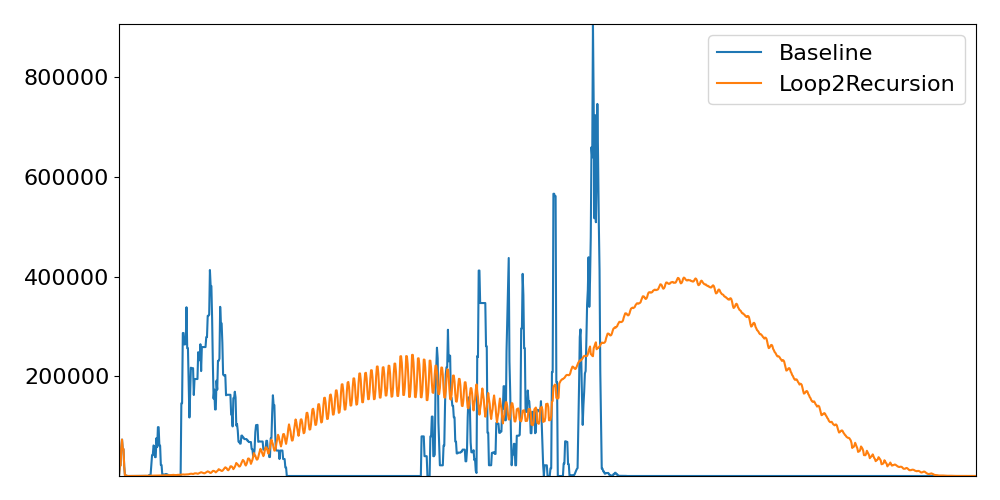

In [5]:
basicmath_figure, basicmath_axes = f('basicmath')

In [6]:
basicmath_figure.savefig('writes_on_stack_addresses_for_benchmark_basicmath_on_cache_less_architecture.pdf')

(<Figure size 1000x500 with 1 Axes>, <AxesSubplot:>)

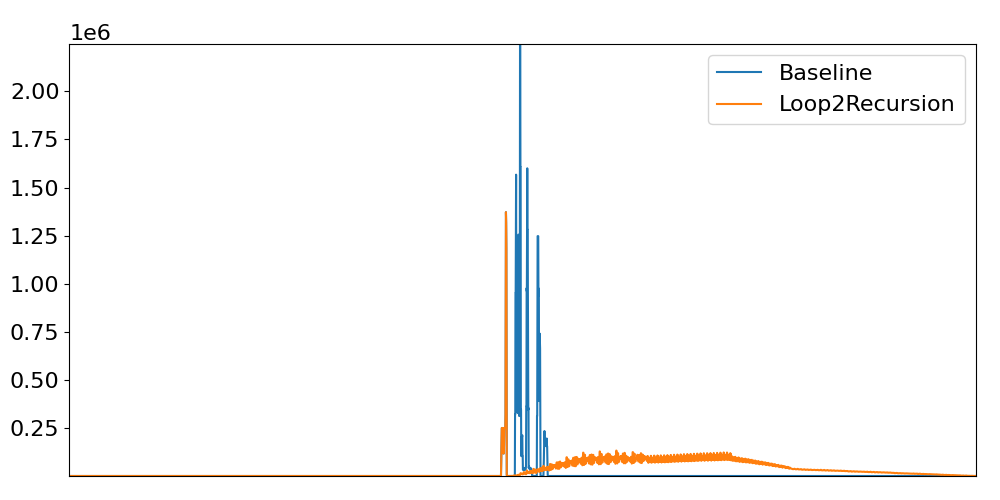

In [7]:
f('bf')

(<Figure size 1000x500 with 1 Axes>, <AxesSubplot:>)

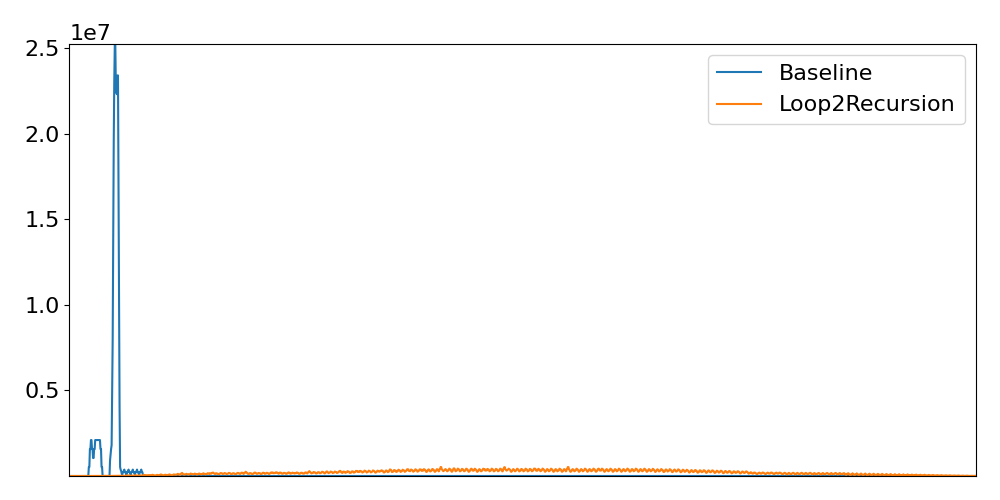

In [8]:
f('bitcnts')

(<Figure size 1000x500 with 1 Axes>, <AxesSubplot:>)

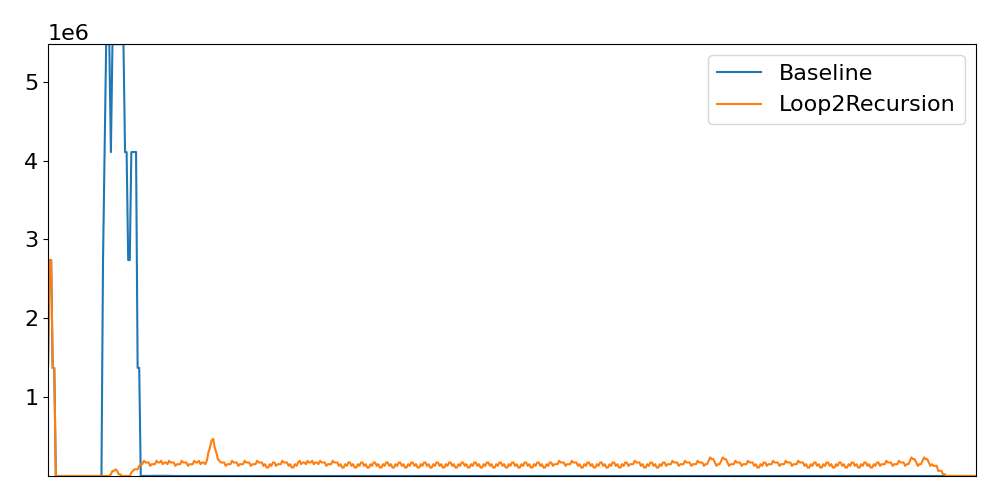

In [9]:
f('crc_32')

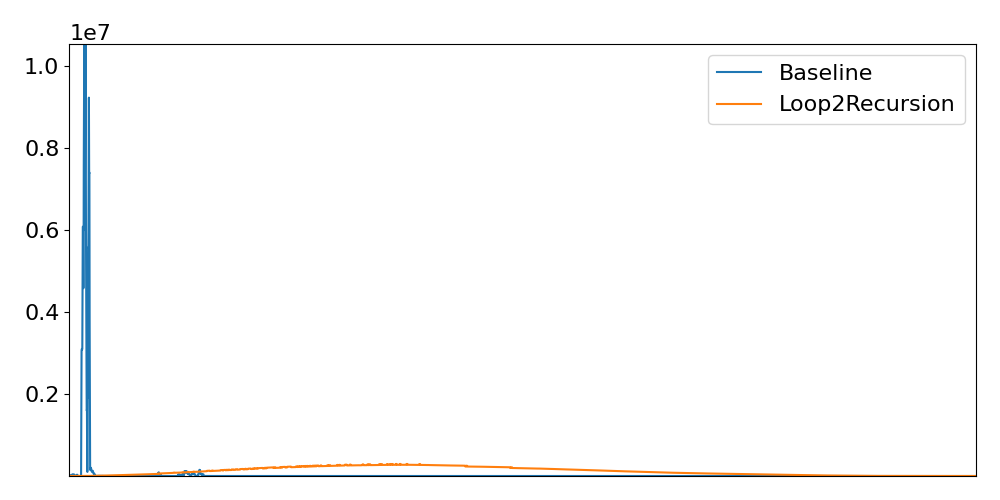

In [10]:
dijkstra_figure, dijkstra_axes = f('dijkstra')

In [11]:
dijkstra_figure.savefig('writes_on_stack_addresses_for_benchmark_dijkstra_on_cache_less_architecture.pdf')

(<Figure size 1000x500 with 1 Axes>, <AxesSubplot:>)

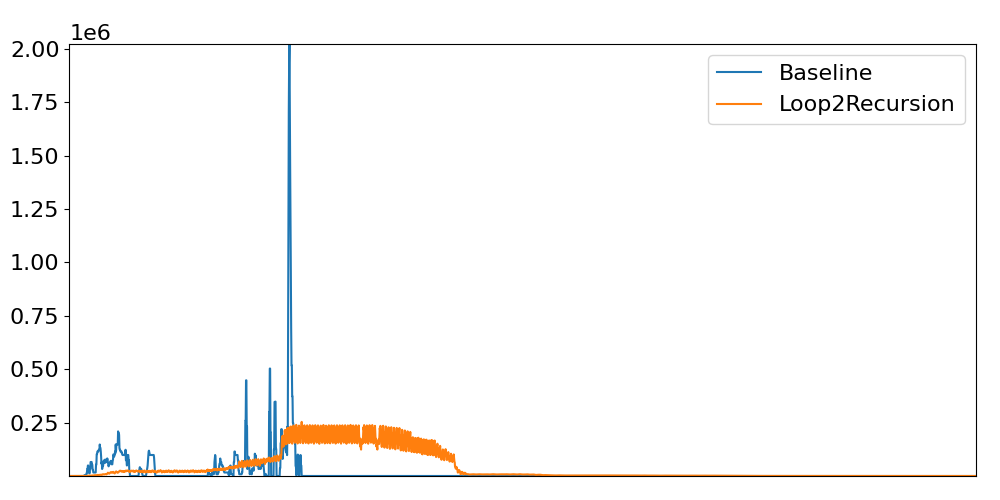

In [12]:
f('fft')

(<Figure size 1000x500 with 1 Axes>, <AxesSubplot:>)

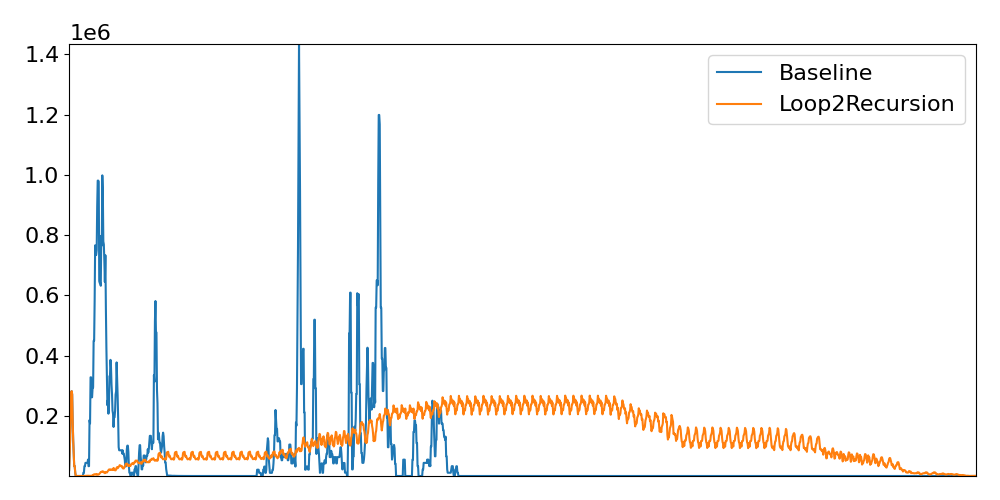

In [13]:
f('patricia')

(<Figure size 1000x500 with 1 Axes>, <AxesSubplot:>)

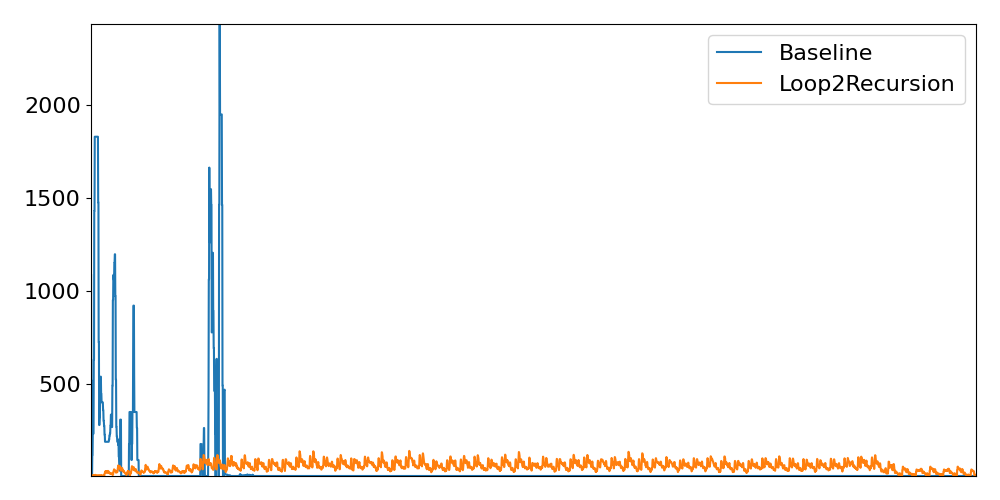

In [14]:
f('pbmsrch')

(<Figure size 1000x500 with 1 Axes>, <AxesSubplot:>)

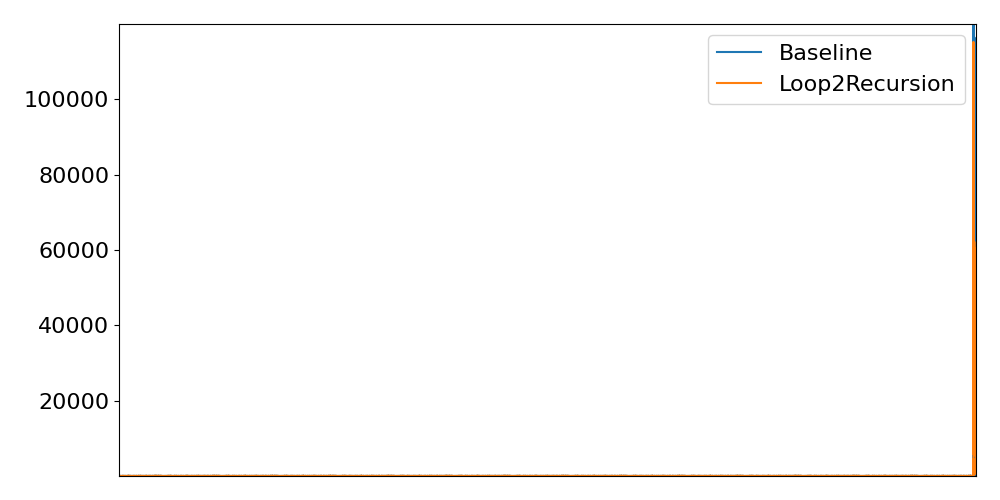

In [15]:
f('qsort')

(<Figure size 1000x500 with 1 Axes>, <AxesSubplot:>)

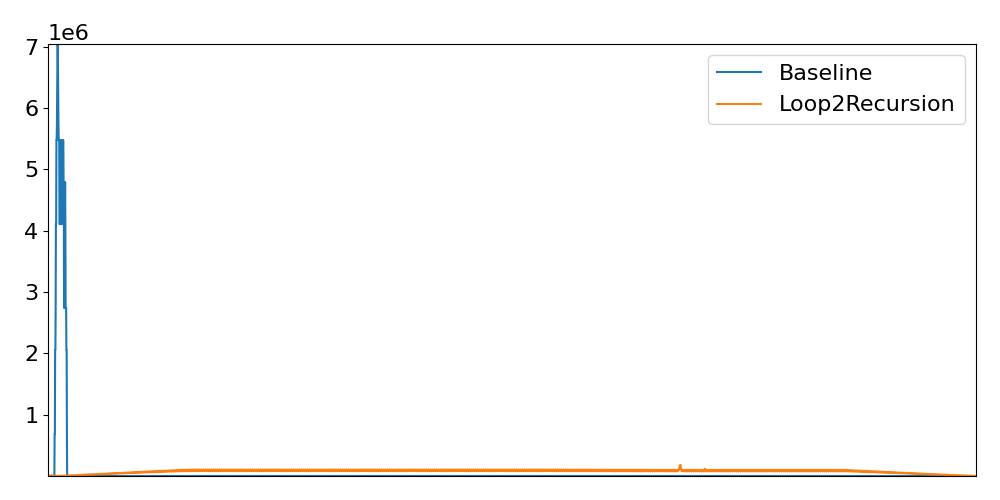

In [16]:
f('rawcaudio')

(<Figure size 1000x500 with 1 Axes>, <AxesSubplot:>)

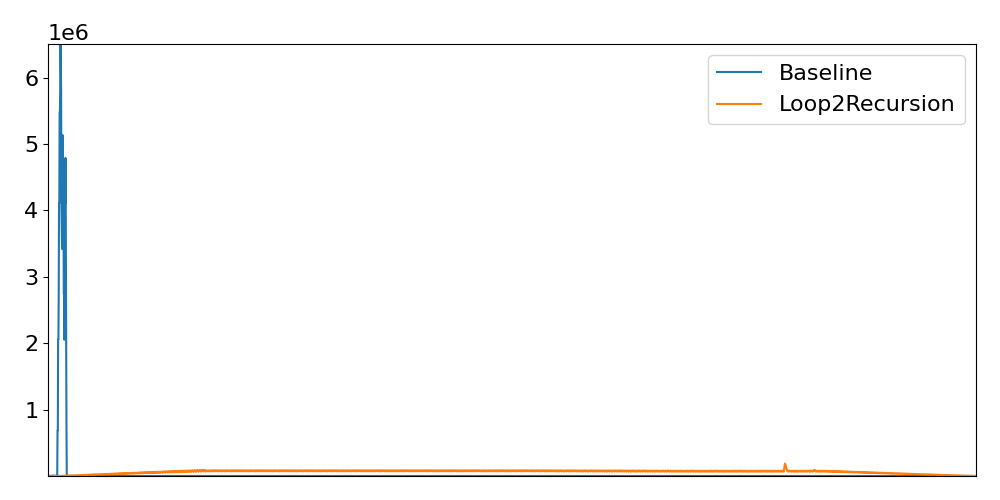

In [17]:
f('rawdaudio')

(<Figure size 1000x500 with 1 Axes>, <AxesSubplot:>)

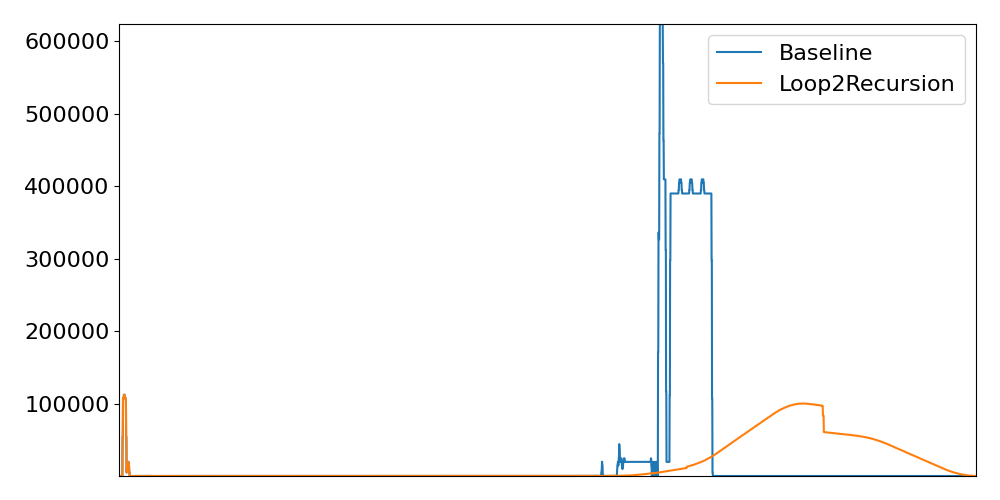

In [18]:
f('sha')

(<Figure size 1000x500 with 1 Axes>, <AxesSubplot:>)

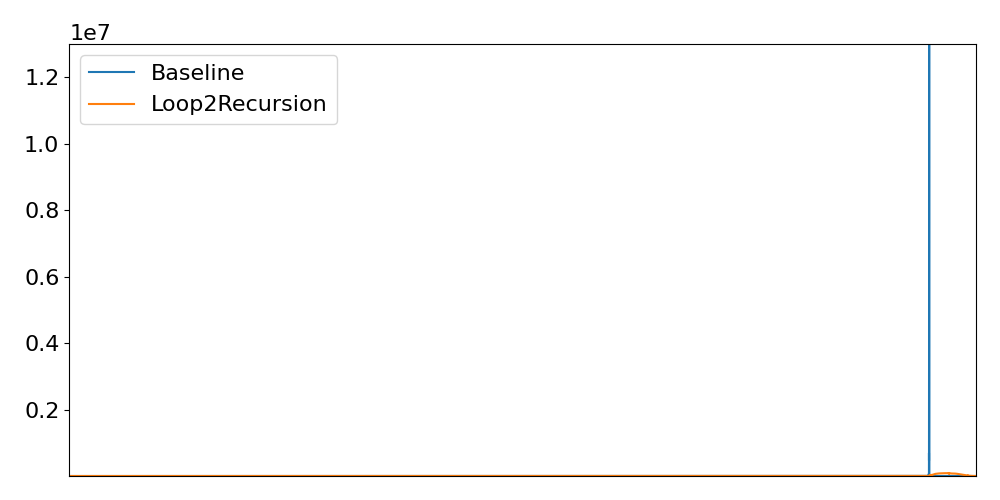

In [19]:
f('susan')